[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/temmyzeus/Fellowship.AI-Challenge/blob/master/Fellowship%20AI-XLNet.ipynb)

### Fetch Data from FastAI S3 Bucket

In [1]:
!wget https://s3.amazonaws.com/fast-ai-nlp/dbpedia_csv.tgz
!tar zxvf dbpedia_csv.tgz && rm dbpedia_csv.tgz

--2022-04-02 14:26:47--  https://s3.amazonaws.com/fast-ai-nlp/dbpedia_csv.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.177.37
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.177.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68341743 (65M) [application/x-tar]
Saving to: ‘dbpedia_csv.tgz’

dbpedia_csv.tgz     100%[===================>]  65.17M  23.0MB/s    in 2.8s    

2022-04-02 14:26:50 (23.0 MB/s) - ‘dbpedia_csv.tgz’ saved [68341743/68341743]

unzip:  cannot find or open https://s3.amazonaws.com/fast-ai-nlp/dbpedia_csv.tgz, https://s3.amazonaws.com/fast-ai-nlp/dbpedia_csv.tgz.zip or https://s3.amazonaws.com/fast-ai-nlp/dbpedia_csv.tgz.ZIP.


In [6]:
!pip install transformers[sentencepiece] -qq

     |████████████████████████████████| 3.8 MB 9.7 MB/s 
     |████████████████████████████████| 895 kB 50.4 MB/s 
     |████████████████████████████████| 6.5 MB 44.9 MB/s 
     |████████████████████████████████| 67 kB 4.8 MB/s 
     |████████████████████████████████| 596 kB 46.0 MB/s 
     |████████████████████████████████| 1.2 MB 45.7 MB/s 


### Import Libraries

In [7]:
import os
import time
import warnings
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from tqdm import tgrange

from IPython.display import Image
import sklearn
from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
from transformers import (
    XLNetConfig,
    XLNetForSequenceClassification,
    XLNetLMHeadModel,
    XLNetModel,
    XLNetTokenizer,
)
from transformers.optimization import AdamW

In [8]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_colwidth", None)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [9]:
data_dir = "dbpedia_csv"

with open(os.path.join(data_dir, "classes.txt"), mode="r") as f:
    classes = f.read()

# split by newlines
classes = classes.strip().split("\n")

# pytorch expects input in 0 <-> n_classes
classes_index = {n: class_ for n, class_ in enumerate(classes)}
# classes_index = {n + 1: class_ for n, class_ in enumerate(classes)}

In [12]:
class_names = ["Class Index", "Title", "Content"]
train = pd.read_csv(os.path.join(data_dir, "train.csv"), names=class_names)
test = pd.read_csv(os.path.join(data_dir, "test.csv"), names=class_names)

print("Train Shape: {}".format(train.shape))
print("Test Shape: {}".format(test.shape))

Train Shape: (560000, 3)
Test Shape: (70000, 3)


In [13]:
# resample  dataset
N_SAMPLES = 50000
train = sklearn.utils.resample(train, n_samples=N_SAMPLES, stratify=train['Class Index'])
train.reset_index(drop=True, inplace=True)

In [14]:
train.head()

,Class Index,Title,Content
0,4,Wayne Edwards (baseball),Wayne Maurice Edwards (born March 7 1964 in Burbank California) is a former Major League Baseball pitcher for the Chicago White Sox. He was drafted by the White Sox in the 10th round of the 1985 Major League Baseball Draft.
1,9,Kashkevar Markazi,Kashkevar (Persian: كشكور‎; also known as Koshkbar and Kūshkehbar) is a village in Aq Kahriz Rural District Nowbaran District Saveh County Markazi Province Iran. At the 2006 census its population was 17 in 4 families.
2,3,Michiko Hamamura,Michiko Hamamura (浜村 美智子 Hamamura Michiko born October 3 1938 in Osaka Japan) is a Japanese singer and actress. She was known as the Banana Boat Girl after she recorded a bi-lingual cover of the Banana Boat Song
3,10,Mallosoma,Mallosoma is a genus of beetles in the family Cerambycidae containing the following species: Mallosoma piptadeniae Giacomel 1976 Mallosoma scutellare White 1853 Mallosoma zonatum (Sahlberg 1823)↑
4,11,Dorstenia grazielae,Dorstenia grazielae is a species of herb in the Moraceae plant family which is native to eastern Brazil.


In [15]:
test.head()

,Class Index,Title,Content
0,1,TY KU,TY KU /taɪkuː/ is an American alcoholic beverage company that specializes in sake and other spirits. The privately-held company was founded in 2004 and is headquartered in New York City New York. While based in New York TY KU's beverages are made in Japan through a joint venture with two sake breweries. Since 2011 TY KU's growth has extended its products into all 50 states.
1,1,Odd Lot Entertainment,OddLot Entertainment founded in 2001 by longtime producers Gigi Pritzker and Deborah Del Prete (The Wedding Planner) is a film production and financing company based in Culver City California.OddLot produced the film version of Orson Scott Card's sci-fi novel Ender's Game. A film version of this novel had been in the works in one form or another for more than a decade by the time of its release.
2,1,Henkel,Henkel AG & Company KGaA operates worldwide with leading brands and technologies in three business areas: Laundry & Home Care Beauty Care and Adhesive Technologies. Henkel is the name behind some of America’s favorite brands.
3,1,GOAT Store,The GOAT Store (Games Of All Type Store) LLC is one of the largest retro gaming online stores and an Independent Video Game Publishing Label. Additionally they are one of the primary sponsors for Midwest Gaming Classic.
4,1,RagWing Aircraft Designs,RagWing Aircraft Designs (also called the RagWing Aeroplane Company and RagWing Aviation) was an American aircraft design and manufacturing company based in Belton South Carolina.


In [16]:
# pytorch expects input in 0 <-> n_classes
train["Class Index"] = train["Class Index"] - 1
test["Class Index"] = test["Class Index"] - 1

In [17]:
train.name = "Train"
test.name = "Test"

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class Index  50000 non-null  int64 
 1   Title        50000 non-null  object
 2   Content      50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class Index  70000 non-null  int64 
 1   Title        70000 non-null  object
 2   Content      70000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [ ]:
# Do we have any duplicated title in train and test?
def get_duplicated_titles(df: pd.DataFrame) -> str:
    n_dup = df.duplicated().sum()
    return "{0} has {1} duplicated titles".format(df.name, n_dup)


print(get_duplicated_titles(train))
print(get_duplicated_titles(test))

Train has 2159 duplicated titles
Test has 0 duplicated titles


In [ ]:
train["Class Index"].value_counts()

4     3572
13    3572
9     3572
10    3572
5     3572
3     3572
0     3571
7     3571
6     3571
1     3571
12    3571
8     3571
2     3571
11    3571
Name: Class Index, dtype: int64

In [ ]:
test["Class Index"].value_counts()

0     5000
1     5000
2     5000
3     5000
4     5000
5     5000
6     5000
7     5000
8     5000
9     5000
10    5000
11    5000
12    5000
13    5000
Name: Class Index, dtype: int64

We observe that att classes in the data have equal instances, so there is no data imbalance whatsoever.

In [ ]:
PRETRAINED_MODEL = "xlnet-base-cased"
xlnet_tokenizer = XLNetTokenizer.from_pretrained(PRETRAINED_MODEL, do_lower_case=True)

In [ ]:
xlnet_model = XLNetModel.from_pretrained(PRETRAINED_MODEL)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def preprocess_text(text: str) -> str:
    return text.strip()


train["Content"] = train["Content"].apply(preprocess_text)
test["Content"] = test["Content"].apply(preprocess_text)

In [ ]:
train["Content"][0]

'Sir Sze-Yuen Chung (traditional Chinese: 鍾士元; simplified Chinese: 钟士元; Mandarin Pinyin: Zhōng Shìyuán; Jyutping: Zung1 Si6 Jyun4; born 3 November 1917 in Hong Kong) GBE GBM is a Hong Kong mechanical engineer industrialist business executive and politician.'

In [ ]:
# This lines runs for quite a while, so
# %%time
# train_content_lens = train['Content'].apply(lambda x: len(xlnet_tokenizer.tokenize(x)))
# test_content_lens = test['Content'].apply(lambda x: len(xlnet_tokenizer.tokenize(x)))

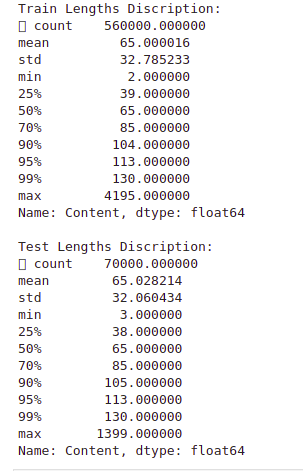

In [ ]:
# percentiles=[.25, .50, .70, .90, .95, .99]

# print('Train Lengths Discription:\n\b',
#       train_content_lens.describe(percentiles=percentiles),
#       '\n\nTest Lengths Discription:\n\b',
#       test_content_lens.describe(percentiles=percentiles))

# Comment the line below if you choose to run the cell above
Image("./data length summary screenshot.png")

In [ ]:
MAX_LEN = 130

In [ ]:
# xlnet_seq_cls_model = XLNetForSequenceClassification.from_pretrained(PRETRAINED_MODEL)
# xlnet_seq_cls_model

In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using: {}".format(DEVICE.type.title()))

if DEVICE.type == "cuda":
    print(f"Using {torch.cuda.device_count()} device: {torch.cuda.get_device_name()}")

Using: Cuda
Using 1 device: Tesla T4


In [ ]:
!nvidia-smi

Tue Feb  8 19:11:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   36C    P0    26W /  70W |      3MiB / 15109MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
TEST_SIZE = 0.25
TARGET = "Class Index"
train, valid = train_test_split(train, test_size=TEST_SIZE, stratify=train[TARGET])
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)

print(f"Train Shape: {train.shape}")
print(f"Validation Shape: {valid.shape}")

Train Shape: (37500, 3)
Validation Shape: (12500, 3)


In [ ]:
_ = xlnet_tokenizer.encode_plus(
    train["Content"][0],
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding="max_length",
    truncation=True,
    return_tensors="pt",
)
_

{'input_ids': tensor([[    5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,    17,  6838,   844,   416,
            66,  2754,    17,    10, 14314,   304,    17,  6838,   844,    48,
           577,  1888,   416,    66,  2754,    17,    88,  3938, 17883,    11,
            17,    10,  1249,    25,    17,  5067,   261,   112,  3743,   155,
           112, 11271,  2392,  5932,    11,    27,    24,   112, 11271,  2392,
            17,   167,  6950,  1406,  3592,    17, 10943,    21,   598,  3324,
            20, 27989,   577,  8710,    17, 19737,   480,    21,  2724,   145,
           515,    25, 11951,   153,     9,    43,    27,   318,    28,  5029,
          4074,    21,  5407,    23,  

In [ ]:
_["input_ids"].size()

torch.Size([1, 130])

In [ ]:
train.head(3)

,Class Index,Title,Content
0,2,Henry Mendez,Henry Méndez (full name Henry Antonio Méndez Reynoso) (born in Santo Domingo Dominican Republic) is a Dominican / Spanish singer songwriter and record producer of reggaeton rap Latin house and dance now based in Spain. He is known for solo hits and collaborations with various artists.
1,12,Inside Nazi Germany,Inside Nazi Germany is a 1938 short documentary film directed by Jack Glenn. It is an episode of the newsreel series The March of Time.In 1993 Inside Nazi Germany was deemed culturally significant by the Library of Congress and selected for preservation in the United States National Film Registry.
2,5,HMS Tuscan (R56),HMS Tuscan (R56) was a T-class destroyer of the British Royal Navy. She was later converted to a Type 16 fast anti-submarine frigate with the new pennant number F156.


In [ ]:
class DBPediaDataset(Dataset):
    TARGET = "Class Index"
    TEXT = "Content"

    def __init__(self, texts, targets, tokenizer=xlnet_tokenizer):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer

    def __len__(self):
        assert len(self.texts) == len(
            self.targets
        ), "Text Length and Target Length must be Same."
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        text = preprocess_text(text)
        target = self.targets[idx]
        out = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": out["input_ids"][0].to(torch.long),
            "attention_mask": out["attention_mask"][0].to(torch.long),
            "token_type_ids": out["token_type_ids"][0].to(torch.long),
            "target": target,
        }

    @classmethod
    def read_from_df(cls, df: pd.DataFrame):
        return cls(df[cls.TEXT].values, df[cls.TARGET].values)

In [ ]:
train_dataset = DBPediaDataset.read_from_df(train)
valid_dataset = DBPediaDataset.read_from_df(valid)

In [ ]:
BATCH_SIZE = 30

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, num_workers=os.cpu_count()
)
valid_dataloader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, num_workers=os.cpu_count()
)

In [ ]:
next(iter(train_dataloader))

{'input_ids': tensor([[5, 5, 5,  ..., 9, 4, 3],
         [5, 5, 5,  ..., 9, 4, 3],
         [5, 5, 5,  ..., 9, 4, 3],
         ...,
         [5, 5, 5,  ..., 9, 4, 3],
         [5, 5, 5,  ..., 9, 4, 3],
         [5, 5, 5,  ..., 9, 4, 3]]),
 'attention_mask': tensor([[0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]]),
 'token_type_ids': tensor([[3, 3, 3,  ..., 0, 0, 2],
         [3, 3, 3,  ..., 0, 0, 2],
         [3, 3, 3,  ..., 0, 0, 2],
         ...,
         [3, 3, 3,  ..., 0, 0, 2],
         [3, 3, 3,  ..., 0, 0, 2],
         [3, 3, 3,  ..., 0, 0, 2]]),
 'target': tensor([ 2, 12,  5,  2,  7, 11,  9,  0,  1,  8, 10,  8, 10,  9,  9,  6,  0,  4,
          8,  7,  6, 10,  9,  9,  3,  0, 12,  5,  3,  7])}

In [ ]:
NUM_CLASSES = train[TARGET].nunique()

In [ ]:
# class XLNetModelCustom(nn.Module):
#     def __init__(self, num_labels=NUM_CLASSES):
#         super().__init__()
#         self.num_labels = num_labels
#         self.xlnet = XLNetModel.from_pretrained(PRETRAINED_MODEL)

#         # XLNet Base has 12 layers starting to count from 0 makes 11
#         out_features = self.xlnet.layer[11].ff.layer_2.out_features
#         self.classifier = torch.nn.Linear(out_features, num_labels)

#     def forward(self, input_ids, attention_mask, token_type_ids, labels):
#         last_hidden_state = self.xlnet(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             token_type=token_type_ids,
#         )
#         # pool outputs into a mean vector
#         mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
#         logits = self.classifier(mean_last_hidden_state)

#         # Return logits for inference & return the loss during training
#         if labels is not None:
#             criterion = CrossEntropyLoss()
#             loss = criterion(logits, labels)
#             return loss
#         else:
#             return logits

#     def freeze_xlnet_decoder(self):
#         """Freeze XLNet weight parameters. They will not be updated during training."""
#         for params in self.xlnet.parameters():
#             params.requires_grad = False

#     def unfreeze_xlnet_decoder(self):
#         """Unfreeze XLNet weight parameters. They will be updated during training."""
#         for params in self.xlnet.parameters():
#             params.requires_grad = True

#     def pool_hidden_state(self, last_hidden_state):
#         """Pool the output vectors into a single mean vector"""
#         last_hidden_state = last_hidden_state[0]
#         mean_last_hidden_state = torch.mean(last_hidden_state, dim=1)
#         return mean_last_hidden_state

In [ ]:
class XLNetModelCustom(nn.Module):
    def __init__(self, num_labels=NUM_CLASSES):
        super().__init__()
        self.num_labels = num_labels
        self.xlnet = XLNetModel.from_pretrained(PRETRAINED_MODEL)

        # XLNet Base has 12 layers starting to count from 0 makes 11
        out_features = self.xlnet.layer[11].ff.layer_2.out_features
        self.classifier = torch.nn.Linear(out_features, num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids):
        last_hidden_state = self.xlnet(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type=token_type_ids,
        )
        # pool outputs into a mean vector
        mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
        logits = self.classifier(mean_last_hidden_state)

        # Return logits for inference & return the loss during training
        # if labels is not None:
        #     criterion = CrossEntropyLoss()
        #     loss = criterion(logits, labels)
        #     return loss
        # else:
        #     return logits
        return logits

    def freeze_xlnet_decoder(self):
        """Freeze XLNet weight parameters. They will not be updated during training."""
        for params in self.xlnet.parameters():
            params.requires_grad = False

    def unfreeze_xlnet_decoder(self):
        """Unfreeze XLNet weight parameters. They will be updated during training."""
        for params in self.xlnet.parameters():
            params.requires_grad = True

    def pool_hidden_state(self, last_hidden_state):
        """Pool the output vectors into a single mean vector"""
        last_hidden_state = last_hidden_state[0]
        mean_last_hidden_state = torch.mean(last_hidden_state, dim=1)
        return mean_last_hidden_state

In [ ]:
# # jsut taking a look at things outside the function
# _ = next(iter(train_dataloader))
# _['input_ids'].shape
# out = xlnet_model(input_ids=_['input_ids'],
#            attention_mask=_['attention_mask'])

# print(out[0].shape, len(out[1]))

# last_hidden_state = out[0]
# print(last_hidden_state.shape)

# mean_last_hidden_state = torch.mean(last_hidden_state, dim=1)
# print(mean_last_hidden_state.shape)

# classifier = nn.Linear(768, 14)
# logits = classifier(mean_last_hidden_state)
# print(logits.shape)

In [ ]:
model = XLNetModelCustom(num_labels=NUM_CLASSES)
model.to(DEVICE)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


XLNetModelCustom(
  (xlnet): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [ ]:
# Check if model is on GPU
next(model.parameters()).device

device(type='cuda', index=0)

In [ ]:
LR = 2e-5
WEIGHT_DECAY = 1e-2

In [ ]:
optimizer = AdamW(
    model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, correct_bias=False
)

In [ ]:
criterion = CrossEntropyLoss()

In [ ]:
EPOCHS = 10

In [ ]:
def train_model(model, dataloader, optimizer, criterion, device=DEVICE):
    model.train()
    start_time = time.time()
    total_loss, total_count = 0, 0

    for data in tqdm(dataloader):
        optimizer.zero_grad()
        input_ids, attention_mask, token_types, targets = (
            data["input_ids"].to(device),
            data["attention_mask"].to(device),
            data["token_type_ids"].to(device),
            data['target'].to(device),
        )
        outputs = model(input_ids, attention_mask, token_types)
        loss = criterion(F.sigmoid(outputs), targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_count += targets.size(0)

    return total_loss / total_count, time.time() - start_time


def evaluate_model(model, dataloader, criterion, device=DEVICE):
    model.eval()
    total_loss, total_count = 0, 0

    with torch.no_grad():
        for data in tqdm(dataloader):
            input_ids, attention_mask, token_types, targets = (
                data["input_ids"].to(device),
                data["attention_mask"].to(device),
                data["token_type_ids"].to(device),
                data['target'].to(device)
            )
            outputs = model(input_ids, attention_mask, token_types)
            loss = criterion(F.sigmoid(outputs), targets)
            total_loss += loss.item()
            total_count += targets.size(0)

    return total_loss / total_count

In [ ]:
path_name = "models"
if not os.path.exists(path_name):
    os.mkdir(path_name)

In [ ]:
# _ = next(iter(train_dataloader))
# input_ids, attention_mask, token_types, target = _["input_ids"].to(DEVICE), _["attention_mask"].to(DEVICE), _["token_type_ids"].to(DEVICE), _["target"].to(DEVICE)

# outputs = model(input_ids, attention_mask, token_types)
# print(outputs.shape)

# print(criterion(F.sigmoid(outputs), target))

In [ ]:
history = defaultdict(list)
best_loss = np.inf
for epoch in range(1, EPOCHS+1):
    train_loss, run_time = train_model(model, train_dataloader, optimizer, criterion)
    eval_loss = evaluate_model(model, valid_dataloader, criterion)
    history["train_loss"].append(train_loss)
    history["eval_loss"].append(eval_loss)
    if eval_loss < best_loss:
        torch.save(model, f'{path_name}/best_model.pt')
        best_loss = eval_loss
    print("-"*71)
    print("| Epoch {}/{} | Time: {:.2f} | Train Loss: {:.5f} | Eval Loss: {:.5f} |".format(epoch,EPOCHS,
                                                             run_time,train_loss,eval_loss))
    print("-"*71)

100%|██████████| 417/417 [02:17<00:00,  3.03it/s]


-----------------------------------------------------------------------
| Epoch 1/10 | Time: 1096.37 | Train Loss: 0.05884 | Eval Loss: 0.05888 |
-----------------------------------------------------------------------


 98%|█████████▊| 1220/1250 [17:57<00:26,  1.15it/s]

In [ ]:
# def train(model,
#           num_epochs,
#           optimizer,
#           train_dataloader,
#           valid_dataloader,
#           model_save_path,
#           train_loss_set=[],
#           valid_loss_set = [],
#           lowest_eval_loss=None,
#           start_epoch=0,
#           device=DEVICE
#           ):
#     """
#     Train the model and save the model with the lowest validation loss
#     """
#     model.to(device)

#     # trange is a tqdm wrapper around the normal python range
#     for i in trange(num_epochs, desc="Epoch"):
#         # if continue training from saved model
#         actual_epoch = start_epoch + i

#         # Training

#         # Set our model to training mode (as opposed to evaluation mode)

#         model.train()

#         # Tracking variables
#         tr_loss = 0
#         num_train_samples = 0

#         # Train the data for one epoch
#         for step, batch in enumerate(train_dataloader):
#           # Add batch to GPU
#           batch = tuple(t.to(device) for t in batch)
#           # Unpack the inputs from our dataloader
#           b_input_ids, b_input_mask, b_labels = batch
#           # Clear out the gradients (by default they accumulate)
#           optimizer.zero_grad()
#           # Forward pass
#           loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
#           # store train loss
#           tr_loss += loss.item()
#           num_train_samples += b_labels.size(0)
#           # Backward pass
#           loss.backward()
#           # Update parameters and take a step using the computed gradient
#           optimizer.step()
#           #scheduler.step()

#         # Update tracking variables
#         epoch_train_loss = tr_loss/num_train_samples
#         train_loss_set.append(epoch_train_loss)

#         print("Train loss: {}".format(epoch_train_loss))

#         # Validation

#         # Put model in evaluation mode to evaluate loss on the validation set
#         model.eval()

#         # Tracking variables
#         eval_loss = 0
#         num_eval_samples = 0

#         # Evaluate data for one epoch
#         for batch in valid_dataloader:
#           # Add batch to GPU
#           batch = tuple(t.to(device) for t in batch)
#           # Unpack the inputs from our dataloader
#           b_input_ids, b_input_mask, b_labels = batch
#           # Telling the model not to compute or store gradients,
#           # saving memory and speeding up validation
#           with torch.no_grad():
#             # Forward pass, calculate validation loss
#             loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
#             # store valid loss
#             eval_loss += loss.item()
#             num_eval_samples += b_labels.size(0)

#         epoch_eval_loss = eval_loss/num_eval_samples
#         valid_loss_set.append(epoch_eval_loss)

#         print("Valid loss: {}".format(epoch_eval_loss))

#         if lowest_eval_loss == None:
#           lowest_eval_loss = epoch_eval_loss
#           # save model
#           save_model(model, model_save_path, actual_epoch,\
#                      lowest_eval_loss, train_loss_set, valid_loss_set)
#         else:
#           if epoch_eval_loss < lowest_eval_loss:
#             lowest_eval_loss = epoch_eval_loss
#             # save model
#             save_model(model, model_save_path, actual_epoch,\
#                        lowest_eval_loss, train_loss_set, valid_loss_set)
#         print("\n")

#       return model, train_loss_set, valid_loss_set


# def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
#   """
#   Save the model to the path directory provided
#   """
#   model_to_save = model.module if hasattr(model, 'module') else model
#   checkpoint = {'epochs': epochs, \
#                 'lowest_eval_loss': lowest_eval_loss,\
#                 'state_dict': model_to_save.state_dict(),\
#                 'train_loss_hist': train_loss_hist,\
#                 'valid_loss_hist': valid_loss_hist
#                }
#   torch.save(checkpoint, save_path)
#   print("Saving model at epoch {} with validation loss of {}".format(epochs,\
#                                                                      lowest_eval_loss))
#   return

In [ ]:
# def load_model(save_path):
#     """
#     Load the model from the path directory provided."""
#     checkpoint = torch.load(save_path)
#     model_state_dict = checkpoint['state_dict']
#     model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
#     model.load_state_dict(model_state_dict)
#     return model